<div style="text-align: center;">
  <h1 style = "font-size = 80px;">TRAITEMENT D'IMAGES</h1>
  <div style = "font-size = 50px;">
    <p>TEAM :</p>
    <p>AMOUSSOU ELI ENOCK EMALIN</p>
    <p>DOHOUN AMOIN MAEVA</p>
    <p>YEO DITCHABA</p>
  </div>
  <p> TAF : Détection des maladies de cabosses de cacaos </p>
</div>

# I. Importation des librairies

In [86]:
import os
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import gabor
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, log_loss, cohen_kappa_score,classification_report, roc_auc_score
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
import joblib
from ultralytics import YOLO
from typing import Dict, List



# II. Chargement des images et annotations

Le code suivant a pour objectif de charger des images(originales) et leurs annotations.

In [ ]:

def load_data(directory):
    images, bboxes = [], []
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        for file in os.listdir(category_path):
            if file.endswith('.jpg'):
                img_path = os.path.join(category_path, file)
                txt_path = img_path.replace('.jpg', '.txt')
                image = load_img(img_path, target_size=(600, 600))
                images.append(img_to_array(image))
                with open(txt_path, 'r') as f:
                    annotations = [list(map(float, line.split())) for line in f.readlines()]
                    bboxes.append(annotations)

    images = np.clip(images, 0, 255).astype(np.uint8)
    return np.array(images), bboxes

data_dir = "Cocoa"
images, bboxes = load_data(data_dir)

# Dictionnaire de couleurs par label
label_colors = {
    0: 'red', # Fitoftora
    1: 'blue', # Monilia
    2: 'orange' # Sana
    }

def plot_bounding_boxes(images, bboxes, index):
    image = images[index]
    plt.imshow(image)

    for bbox in bboxes[index]:
        label, x, y, w, h = bbox
        x1, y1, x2, y2 = (x-w/2)*600, (y-h/2)*600, (x+w/2)*600, (y+h/2)*600

        # Récupérer la couleur correspondante au label
        color = label_colors.get(int(label), 'black')  # 'black' par défaut si le label n'est pas dans le dictionnaire

        # Dessiner le rectangle avec la couleur correspondante
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor=color, facecolor='none'))

        # Ajouter le texte avec la couleur correspondante
        plt.text(x1, y1 - 5, int(label), color=color, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()


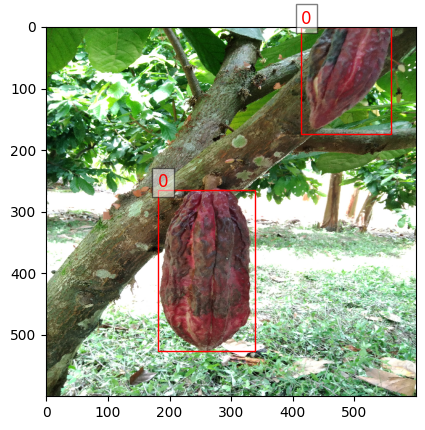

In [ ]:
plot_bounding_boxes(images, bboxes, 0)

On a ainsi une visualisation claire des objets détectés dans une image au travers des boîtes englobantes et des labels. Cela permet de vérifier facilement la qualité des annotations et la précision de la détection d'objets.

### II.1. SEGMENTATION DES IMAGES

Ici, on définit une fonction **load_and_segment_cabosses** qui charge des images de cabosses et leurs annotations, puis extrait les régions d'intérêt (les cabosses) en fonction des boîtes englobantes fournies.

In [3]:

def load_and_segment_cabosses(directory):
    cabosses = []
    labels = []
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        for file in os.listdir(category_path):
            if file.endswith('.jpg'):
                img_path = os.path.join(category_path, file)
                txt_path = img_path.replace('.jpg', '.txt')
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                h, w, _ = image.shape
                with open(txt_path, 'r') as f:
                    for line in f.readlines():
                        values = list(map(float, line.split()))
                        label, x, y, bw, bh = values
                        x1, y1 = int((x - bw / 2) * w), int((y - bh / 2) * h)
                        x2, y2 = int((x + bw / 2) * w), int((y + bh / 2) * h)
                        cabosse = image[y1:y2, x1:x2]
                        cabosse = cv2.resize(cabosse, (224, 224))
                        cabosses.append(cabosse)
                        labels.append(int(label))
    return np.array(cabosses), np.array(labels)


In [ ]:
cabosses, labels = load_and_segment_cabosses(data_dir)

In [ ]:
print("cabosses.shape =",cabosses.shape,'et labels.shape =', labels.shape)

cabosses.shape = (1591, 224, 224, 3) et labels.shape = (1591,)


- **1591** , c'est le nombre total de cabosses détectées et extraites.

- Chaque images (cabosse) à pour dimension (224, 224, 3) → une image à 3 couches RVB.

In [ ]:
print(pd.DataFrame(labels).value_counts(normalize= True))

0
2    0.766185
0    0.142678
1    0.091138
Name: proportion, dtype: float64


On remarque ainsi un déséquilibre entres les différentes classes avec la Classe 2 fortement majoritaire par rapport aux classes 0 et 1

In [ ]:
print(f"La proportion de la classe 2 fait environ",
      int(pd.DataFrame(labels).value_counts()[2]/pd.DataFrame(labels).value_counts()[0]),
       "fois celle de la classe 0 et envriron",
       int(pd.DataFrame(labels).value_counts()[2]/pd.DataFrame(labels).value_counts()[1]),
       "fois celle de la classe 1"
       )

La proportion de la classe 2 fait environ 5 fois celle de la classe 0 et envriron 8 fois celle de la classe 1


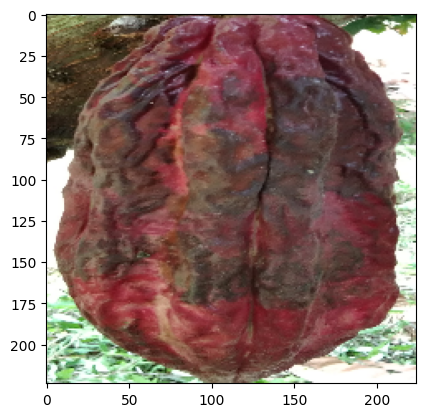

In [ ]:
plt.imshow(cabosses[0])

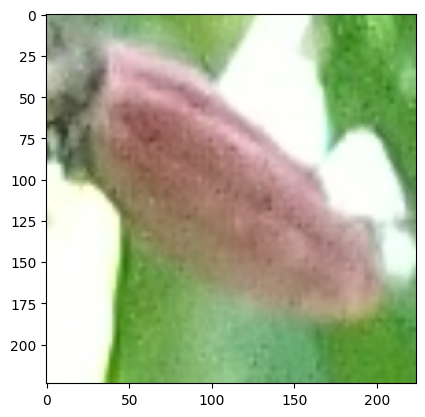

In [ ]:
plt.imshow(cabosses[10])

# III. Augmentation de l'ensemble de données

Spécifiquement nous allons augmenter les données(images) des classes minoritaires.

In [6]:
cabosses = cabosses.astype('float32') / 255.0  # Normalisation entre 0 et 1

**Normalisation** :

Les valeurs des pixels de toutes les images de cabosses sont maintenant comprises entre 0 et 1.

Par la suite il s'agira d'augmenter le jeu de données en créant de nouvelles variantes des images existantes grâce à des rotations.

Augmenter la taille du jeu de données permettra d'améliorer la robustesse et la généralisation de nos modèles de ML

AxesImage(shape=(224, 224, 3))


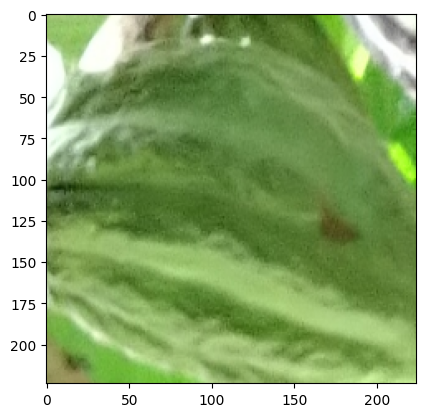

In [5]:
from scipy.ndimage import rotate

def rotate_image(image, angle):
    """Effectue une rotation d'image avec une interpolation de qualité."""
    return rotate(image, angle, reshape=False, mode='nearest')

# Exemple de rotation d'une image
rotated_image = rotate(cabosses[158], 90)
print(plt.imshow(rotated_image))

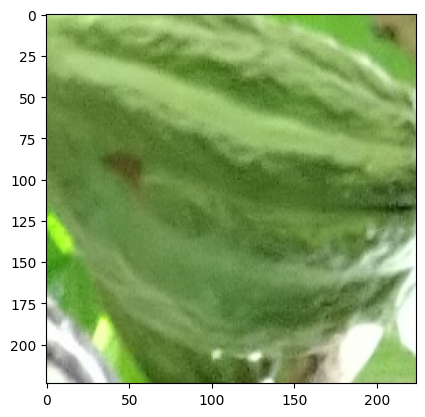

In [ ]:
rotated_image = rotate(cabosses[158], -90)
plt.imshow(rotated_image)

### III.1. Augmentation des images de la classe 0

In [7]:
augmented_images_class0 = []
augmented_labels_class0= []

labels_ = labels[(labels != 2) & (labels != 1)]
cabosses_ = cabosses[(labels != 2) & (labels != 1)]
for image, label in zip(cabosses_, labels_):
    rotated_image_1 = rotate_image(image, 45)
    rotated_image_2 = rotate_image(image, -45)
    rotated_image_3 = rotate_image(image, -90)
    rotated_image_4 = rotate_image(image, 90)
    rotated_image_5 = rotate_image(image, 180)
    augmented_images_class0.extend([rotated_image_1, rotated_image_2,rotated_image_3,rotated_image_4,rotated_image_5])
    augmented_labels_class0.extend([label, label, label, label, label])

augmented_images_class0 = np.array(augmented_images_class0)
augmented_labels_class0 = np.array(augmented_labels_class0)


### III.2. Augmentation des images de la classe 1

In [8]:
augmented_images_class1 = []
augmented_labels_class1 = []

labels_ = labels[(labels != 2) & (labels != 0)]
cabosses_ = cabosses[(labels != 2) & (labels != 0)]
for image, label in zip(cabosses_, labels_):
    rotated_image_1 = rotate_image(image, 45)
    rotated_image_2 = rotate_image(image, -45)
    rotated_image_3 = rotate_image(image, -90)
    rotated_image_4 = rotate_image(image, 90)
    rotated_image_5 = rotate_image(image, 180)
    rotated_image_6 = rotate_image(image, 135)
    rotated_image_7 = rotate_image(image, 225)
    augmented_images_class1.extend([rotated_image_1, rotated_image_2,rotated_image_3,rotated_image_4,rotated_image_5,rotated_image_6,rotated_image_7])
    augmented_labels_class1.extend([label, label, label, label, label, label, label])

augmented_images_class1 = np.array(augmented_images_class1)
augmented_labels_class1 = np.array(augmented_labels_class1)


In [9]:
cabosses = np.concatenate([cabosses, augmented_images_class0, augmented_images_class1])
labels = np.concatenate([labels, augmented_labels_class0, augmented_labels_class1])

print(f"Forme des données augmentées : {cabosses.shape}")
print(f"Forme des labels augmentés : {labels.shape}")
print(pd.DataFrame(labels).value_counts(normalize= True))

Forme des données augmentées : (3741, 224, 224, 3)
Forme des labels augmentés : (3741,)
0
0    0.364074
2    0.325849
1    0.310078
Name: proportion, dtype: float64


**cabosses.shape = (3741, 224, 224, 3)** :

- 3741 : Le nombre total d'images après augmentation.

  - Initialement, il y avait 1591 images;

  - Pour les images la classe 0, 5 nouvelles images ont été ajoutées (rotation de 45°,-45°, -90°, 90° et 180°).

  - Pour les images la classe 1, 7 nouvelles images ont été ajoutées (rotation de 45°,-45°, -90°, 90°, 180°, 135° et 225°);

  - Donc, 1591 + (227 * 5) + (145 * 7) = 3741



**labels.shape = (3741,) :**

- 3741 : Le nombre total de labels après augmentation.

  - Chaque image augmentée a le même label que l'image originale.

# IV. Extraction des caractéristiques

### IV.1. Extraction des caractéristiques CNN après entraînement avec EMA

Le code suivant vise à classifier des images.

**Paramètres des modèles CNN** :

- **weights='imagenet'** : Utilise les poids pré-entraînés sur ImageNet.

- **include_top=False** : Exclut la couche de classification finale (fully connected) pour pouvoir ajouter un classifieur personnalisé.

- **input_shape=(224, 224, 3)**: Définit la forme d'entrée des images (224x224 pixels, 3 canaux RGB).

In [ ]:
# Dossier où sauvegarder les modèles
save_dir = "models/cnn"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
cnn_models = {
    "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

def create_feature_extractor_with_classifier(model, num_classes):
    """Crée un extracteur de caractéristiques avec un classifieur."""
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) #elu et regularisation l2
    x = BatchNormalization()(x) #ajout du batch normalization
    outputs = Dense(num_classes, activation='softmax')(x)
    feature_extractor_with_classifier = Model(inputs=model.input, outputs=outputs)
    return feature_extractor_with_classifier

num_classes = len(set(labels))
models_with_classifier = {name: create_feature_extractor_with_classifier(model, num_classes) for name, model in cnn_models.items()}

# EMA Optimizer
class EMAOptimizer:
    def __init__(self, optimizer, decay=0.99):
        self.optimizer = optimizer
        self.decay = decay
        self.ema_vars = {}

    def apply_gradients(self, grads_and_vars):
        self.optimizer.apply_gradients(grads_and_vars)
        for grad, var in grads_and_vars:
            if grad is not None:
                if var.ref() not in self.ema_vars:
                    self.ema_vars[var.ref()] = tf.Variable(var, trainable=False)
                self.ema_vars[var.ref()].assign(self.decay * self.ema_vars[var.ref()] + (1 - self.decay) * var)

    def get_ema_weights(self):
        return {var.ref(): ema_var.numpy() for var, ema_var in self.ema_vars.items()}

learning_rate_schedule = ExponentialDecay(0.001, decay_steps=1000, decay_rate=0.96)

# Entraînement des modèles avec classifieur et EMA
for name, model in models_with_classifier.items():
    ema_optimizer = EMAOptimizer(tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule), decay=0.99)
    model.compile(optimizer=ema_optimizer.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(cabosses, labels, epochs=4, batch_size=32)
    # Sauvegarde du modèle
    model_path = os.path.join(save_dir, f"{name}_with_classifier.h5")
    model.save(model_path)
    print(f"Modèle {name} sauvegardé à {model_path}")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/4
117/117 ━━━━━━━━━━━━━━━━━━━━ 1669s 14s/step - accuracy: 0.7319 - loss: 1.3149
Epoch 2/4
117/117 ━━━━━━━━━━━━━━━━━━━━ 1606s 13s/step - accuracy: 0.9513 - loss: 0.5300
Epoch 3/4
117/117 ━━━━━━━━━━━━━━━━━━━━ 1544s 13s/step - accuracy: 0.9663 - loss: 0.4121
Epoch 4/4
117/117 ━━━━━━━━━━━━━━━━━━━━ 1606s 13s/step - accuracy: 0.9646 - loss: 0.3328


AttributeError: 'EMAOptimizer' object has no attribute 'assign_ema_weights_to_model'

In [ ]:
cnn_models = {
    "EfficientNetB0": load_model("models/cnn/EfficientNetB0_with_classifier.h5"),
    "MobileNetV2": load_model("models/cnn/MobileNetV2_with_classifier.h5")
        }

#On récupère la sortie de la couche Dense(256)
feature_extractors = {name: Model(inputs=model.input, outputs=model.layers[-2].output) for name, model in cnn_models.items()}

cnn_features = {name: extractor.predict(cabosses) for name, extractor in feature_extractors.items()}

117/117 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step


In [13]:
[f"{name} features shape {cnn_features[name].shape}" for name in cnn_features]

['EfficientNetB0 features shape (3741, 256)',
 'MobileNetV2 features shape (3741, 256)']

**3741 x 256**

256 , c'est lié la taille du vecteur de fonctionnalités dans **Dense(256, activation='elu')**

**L'optimisateur EMA**

ici il joue le rôle de stabilisateur dans  l'apprentissage des modèles CNN en lissant l'évolution des poids au fil du temps. Plutôt que d'utiliser uniquement les poids appris à chaque étape (qui peuvent être bruyants à cause des mini-batchs), l'EMA calcule une moyenne pondérée des poids passés et présents , ce qui permet d'avoir des modèles plus robustes, plus stables , et qui généralisent mieux sur les données.

### IV.2. Extraction de caractéristiques supplémentaires (texture, couleur, forme)

On extrait des caractéristiques supplémentaires (texture, couleur et forme) à partir des images de cabosses.

In [14]:

def extract_texture(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Conversion en uint8 si nécessaire
    gray_uint8 = (gray * 255).astype(np.uint8) if gray.dtype in [np.float32, np.float64] else gray

    distances = [1, 3, 5, 0, 0]
    angles = [0, 0, 0, np.pi/4, np.pi/2]

    features = []
    for d, a in zip(distances, angles):
        glcm = graycomatrix(gray_uint8, distances=[d], angles=[a], levels=256, symmetric=True, normed=True)
        features.extend([
            graycoprops(glcm, 'contrast')[0, 0],
            graycoprops(glcm, 'correlation')[0, 0],
            graycoprops(glcm, 'energy')[0, 0],
            graycoprops(glcm, 'homogeneity')[0, 0],
            graycoprops(glcm, 'dissimilarity')[0, 0]
        ])

    return np.array(features)



def extract_color_histogram(image):
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    return hist.flatten()

def extract_hu_moments(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    moments = cv2.moments(gray)
    hu_moments = cv2.HuMoments(moments)
    return hu_moments.flatten()

def extract_all_features(images):
    all_features = []
    for image in images:
        texture_features = extract_texture(image)
        color_features = extract_color_histogram(image)
        shape_features = extract_hu_moments(image)
        combined_features = np.concatenate([texture_features, color_features, shape_features])
        all_features.append(combined_features)
    return np.array(all_features)

additional_features = extract_all_features(cabosses)


In [ ]:
additional_features.shape

(3741, 544)

Pour chaque image, on a pu extraire 544 fonctionnalités, reparties comme suit :

- 25 fonctionnalités de texture via les matrices GLCM sur 5 directions, avec 5 mesures (contraste, corrélation, énergie, homogénéité, dissemblance). Donc : 5 distances/angles * 5 propriétés = 25.

- 512 fonctionnalités de couleur grâce à un histogramme RGB (8 bins par canal)donc 8 * 8 * 8 = 512.

- 7 longs métrages de forme avec les moments de Hu.

### IV.3. Concaténation des caractéristiques CNN et supplémentaires

On fusionne les fonctionnalités du CNN avec les fonctionnalités manuelles (texture, couleur, forme) pour créer un super vecteur de caractéristiques .

In [15]:
# combinaison de caractéristiques CNN et supplémentaires
all_features = np.hstack([cnn_features[name] for name in cnn_features] + [additional_features])

print(f"All features shape: {all_features.shape}")

All features shape: (3741, 1056)


# V. Modélisation

### V.1. Division des données en ensembles Train et Test

Dans cette phase:
- Nous divisons les données en ensembles d'entraînement et de test, et appliquons une Analyse en Composantes Principales (ACP) pour réduire la dimensionnalité des caractéristiques;
- Nous construisons , entrainons et évaluons nos modèles Ml (SVM et CatBoost)

In [26]:
all_features, labels = np.load("Data.npz")["features"], np.load("Data.npz")["labels"]

In [ ]:
# Création du modèle PCA avec 95% de variance conservée
pca = PCA(n_components=0.95)  
pca.fit(all_features)

# Sauvegarde du modèle PCA dans un fichier .pkl
with open("models/pca/pca.pkl", "wb") as f:
    pickle.dump(pca, f)

PCA(n_components=0.95)

In [27]:
pca_features = pca.transform(all_features)
X_train, X_test, y_train, y_test = train_test_split(pca_features, labels, test_size=0.2,stratify=labels, random_state=42)

print(X_train.shape)

(2992, 187)


L'ACP ,sur les caractéristiques CNN + suppléméntaires, a ainsi permis de passer de 1056 caractéristiques à 187.

### V.2. Entraînement et évaluation du modèle SVM

### Application d'un Random Search sur C (paramètre de régularisation) pour un SVM avec noyau RBF

In [ ]:
# Modèle SVM de base
svm = SVC(kernel='rbf', probability=True, random_state=42)

# Liste des valeurs précises de C
param_dist = {
    'C': [1, 10, 100, 1000, 5000, 1e4, 5e4 ,1e5 ,5e5, 1e6 ,5e6 ,1e7, 5e7 ,1e8 ,5e8, 1e9 ,5e9]
}

# Random Search 
random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,            
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Entraînement
random_search.fit(X_train, y_train)

# Résultat
print("Meilleur C :", random_search.best_params_['C'])
print("Score :", random_search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleur C : 10000000.0
Score : 0.8345536875841006


In [77]:
svm = SVC(
        kernel='rbf', 
        probability=True, 
        C= random_search.best_params_['C'],
        random_state=42
        )

svm.fit(X_train, y_train)

SVC(C=10000000.0, probability=True, random_state=42)

In [57]:
# Fonction d'évaluation
def plot_evaluation(model, X_test, y_test, model_name="SVM"):
    # Prédictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # Courbe ROC par classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_prob.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Moyenne Macro-AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])  # Interpolation des points de la courbe

    mean_tpr /= n_classes  # Moyenne des TPR

    roc_auc_macro = auc(all_fpr, mean_tpr)  # AUC Macro

    # Métriques générales
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    cross_entropy = log_loss(y_test, y_prob)
    kappa = cohen_kappa_score(y_test, y_pred)

    # Affichage
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Courbes ROC
    for i in range(n_classes):
        ax1.plot(fpr[i], tpr[i], label=f'Class {i} AUC = {roc_auc[i]:.2f}')
    ax1.plot(all_fpr, mean_tpr, label=f'Avg-AUC = {roc_auc_macro:.2f}', linestyle='dashed', linewidth=2, color='red')
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC)')
    ax1.legend(loc="lower right")

    # Table des métriques
    metrics_table = {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1,
        "cross_entropy": cross_entropy,
        "cohen_kappa": kappa
    }
    ax2.axis('off')
    ax2.table(cellText=[[k, f"{v:.6f}"] for k, v in metrics_table.items()],
              colLabels=[model_name, "Value"],
              cellLoc='center',
              loc='center')
    ax2.set_title('Model Scores')

    plt.tight_layout()
    plt.show()



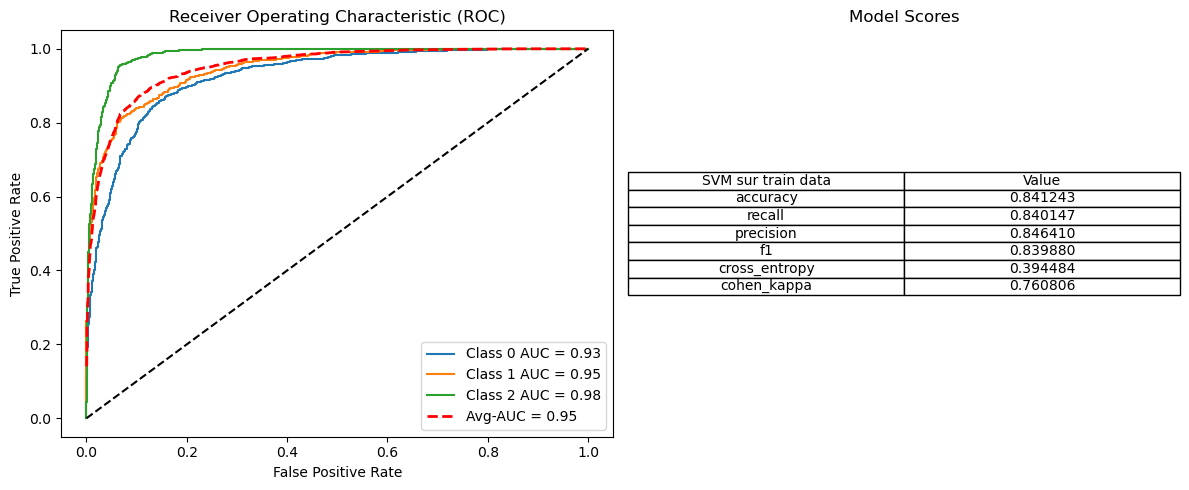

In [83]:
plot_evaluation(svm, X_train, y_train, model_name="SVM sur train data")

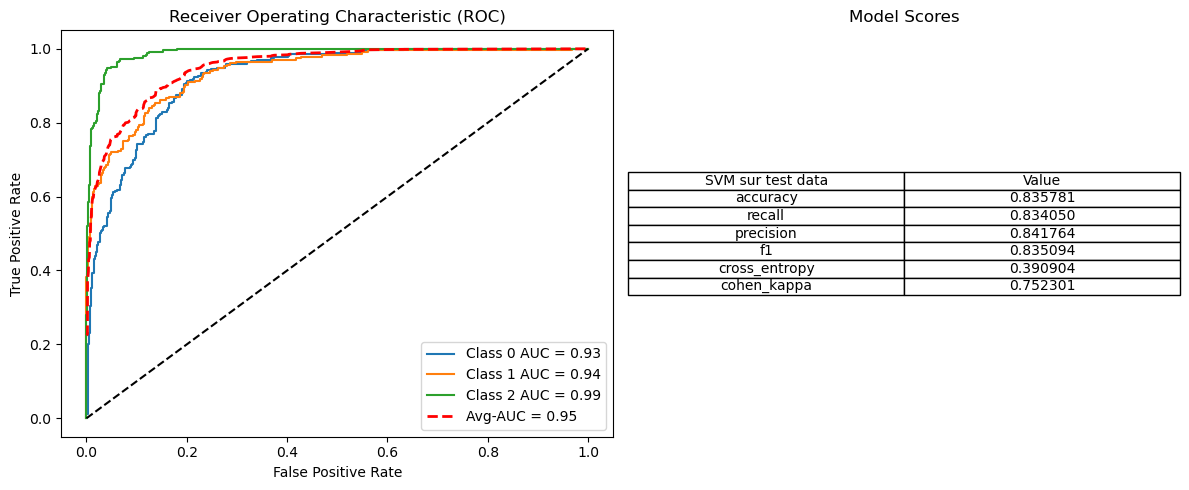

In [84]:
plot_evaluation(svm, X_test, y_test, model_name="SVM sur test data")

Ainsi nous somme sûr de ne pas être dans un cas de surapprentissage

In [79]:
# Sauvegarde du modèle svm dans un fichier .pkl
with open("models/pca/model_svm.pkl", "wb") as f:
    pickle.dump(svm, f)

# VI. Réunification des différents process

### VI.1. Création d'une classe pour l'extraction de toutes les caractéristiques

In [87]:

class FeatureExtractor:
    def __init__(self, cnn_model_paths: Dict[str, str]):
        """
        Initialise les extracteurs de caractéristiques
        
        Args:
            cnn_model_paths: Dictionnaire des chemins vers les modèles CNN
                Format: {"nom_modele": "chemin/vers/modele.h5"}
        """
        self.cnn_model_paths = cnn_model_paths
        self.cnn_models = self._load_cnn_models()
        self.feature_extractors = self._create_feature_extractors()
        
    def _load_cnn_models(self) -> Dict[str, Model]:
        """Charge les modèles CNN à partir des chemins"""
        models = {}
        for name, path in self.cnn_model_paths.items():
            try:
                models[name] = load_model(path)
                print(f"Modèle {name} chargé avec succès depuis {path}")
            except Exception as e:
                print(f"Erreur lors du chargement du modèle {name} depuis {path}: {str(e)}")
                models[name] = None
        return models
    
    def _create_feature_extractors(self) -> Dict[str, Model]:
        """Crée les extracteurs de features (couche avant la dernière)"""
        extractors = {}
        for name, model in self.cnn_models.items():
            if model is not None:
                try:
                    extractors[name] = Model(inputs=model.input, outputs=model.layers[-2].output)
                    print(f"Extracteur créé pour {name}")
                except Exception as e:
                    print(f"Erreur lors de la création de l'extracteur pour {name}: {str(e)}")
                    extractors[name] = None
        return extractors
    
    def extract_cnn_features(self, images: np.ndarray) -> Dict[str, np.ndarray]:
        """
        Extrait les features CNN pour tous les modèles
        
        Args:
            images: Batch d'images (shape: [n_images, height, width, channels])
            
        Returns:
            Dictionnaire des features par modèle {"nom_modele": features_array}
        """
        return {
            name: extractor.predict(images)
            for name, extractor in self.feature_extractors.items()
        }
    
    @staticmethod
    def extract_texture_features(image: np.ndarray) -> np.ndarray:
        """
        Extrait les caractéristiques de texture (GLCM)
        
        Args:
            image: Image RGB [height, width, 3]
            
        Returns:
            Vecteur de features de texture (25 éléments)
        """
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray_uint8 = (gray * 255).astype(np.uint8) if gray.dtype in [np.float32, np.float64] else gray

        distances = [1, 3, 5, 0, 0]
        angles = [0, 0, 0, np.pi/4, np.pi/2]

        features = []
        for d, a in zip(distances, angles):
            glcm = graycomatrix(gray_uint8, distances=[d], angles=[a], levels=256, symmetric=True, normed=True)
            features.extend([
                graycoprops(glcm, 'contrast')[0, 0],
                graycoprops(glcm, 'correlation')[0, 0],
                graycoprops(glcm, 'energy')[0, 0],
                graycoprops(glcm, 'homogeneity')[0, 0],
                graycoprops(glcm, 'dissimilarity')[0, 0]
            ])

        return np.array(features)
    
    @staticmethod
    def extract_color_features(image: np.ndarray) -> np.ndarray:
        """
        Extrait les caractéristiques de couleur (histogramme)
        
        Args:
            image: Image RGB [height, width, 3]
            
        Returns:
            Vecteur de features de couleur (512 éléments)
        """
        hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        return hist.flatten()
    
    @staticmethod
    def extract_shape_features(image: np.ndarray) -> np.ndarray:
        """
        Extrait les caractéristiques de forme (moments de Hu)
        
        Args:
            image: Image RGB [height, width, 3]
            
        Returns:
            Vecteur de features de forme (7 éléments)
        """
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        moments = cv2.moments(gray)
        hu_moments = cv2.HuMoments(moments)
        return hu_moments.flatten()
    
    def extract_handcrafted_features(self, images: List[np.ndarray]) -> np.ndarray:
        """
        Extrait toutes les caractéristiques traditionnelles (texture, couleur, forme)
        
        Args:
            images: Liste d'images RGB
            
        Returns:
            Array des features combinées [n_images, n_features]
        """
        all_features = []
        for image in images:
            texture = self.extract_texture_features(image)
            color = self.extract_color_features(image)
            shape = self.extract_shape_features(image)
            combined = np.concatenate([texture, color, shape])
            all_features.append(combined)
            
        return np.array(all_features)
    
    def extract_all_features(self, images: np.ndarray, normalize: bool = True) -> np.ndarray:
        """
        Extrait toutes les caractéristiques (CNN + traditionnelles)
        
        Args:
            images: Batch d'images [n_images, height, width, channels]
            normalize: Si True, normalise les features
            
        Returns:
            Array combiné de toutes les features [n_images, total_features]
        """
        # Features CNN
        cnn_features_dict = self.extract_cnn_features(images)
        cnn_features = np.hstack([cnn_features_dict[name] for name in cnn_features_dict])
        
        # Features traditionnelles
        handcrafted_features = self.extract_handcrafted_features(images)
        
        # Combinaison
        all_features = np.hstack([cnn_features, handcrafted_features])
        
        if normalize:
            scaler = StandardScaler()
            all_features = scaler.fit_transform(all_features)
            
        return all_features
    

# Initialisation
model_paths = {
    "EfficientNetB0": "models/cnn/EfficientNetB0_with_classifier.h5",
    "MobileNetV2": "models/cnn/MobileNetV2_with_classifier.h5"
}

extractor = FeatureExtractor(model_paths)

Modèle EfficientNetB0 chargé avec succès depuis models/cnn/EfficientNetB0_with_classifier.h5


Modèle MobileNetV2 chargé avec succès depuis models/cnn/MobileNetV2_with_classifier.h5
Extracteur créé pour EfficientNetB0
Extracteur créé pour MobileNetV2


### VI.2. Reprise du pipeline avec les modèles sérialisés


image 1/1 c:\Users\AMOUSSOU\Documents\MASTER 2 DATA SCIENCE\Apprentissage profond (DEEP LEARNING)\PROJET\Images\Fito1.jpg: 640x480 10 cabosses, 161.3ms
Speed: 4.2ms preprocess, 161.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


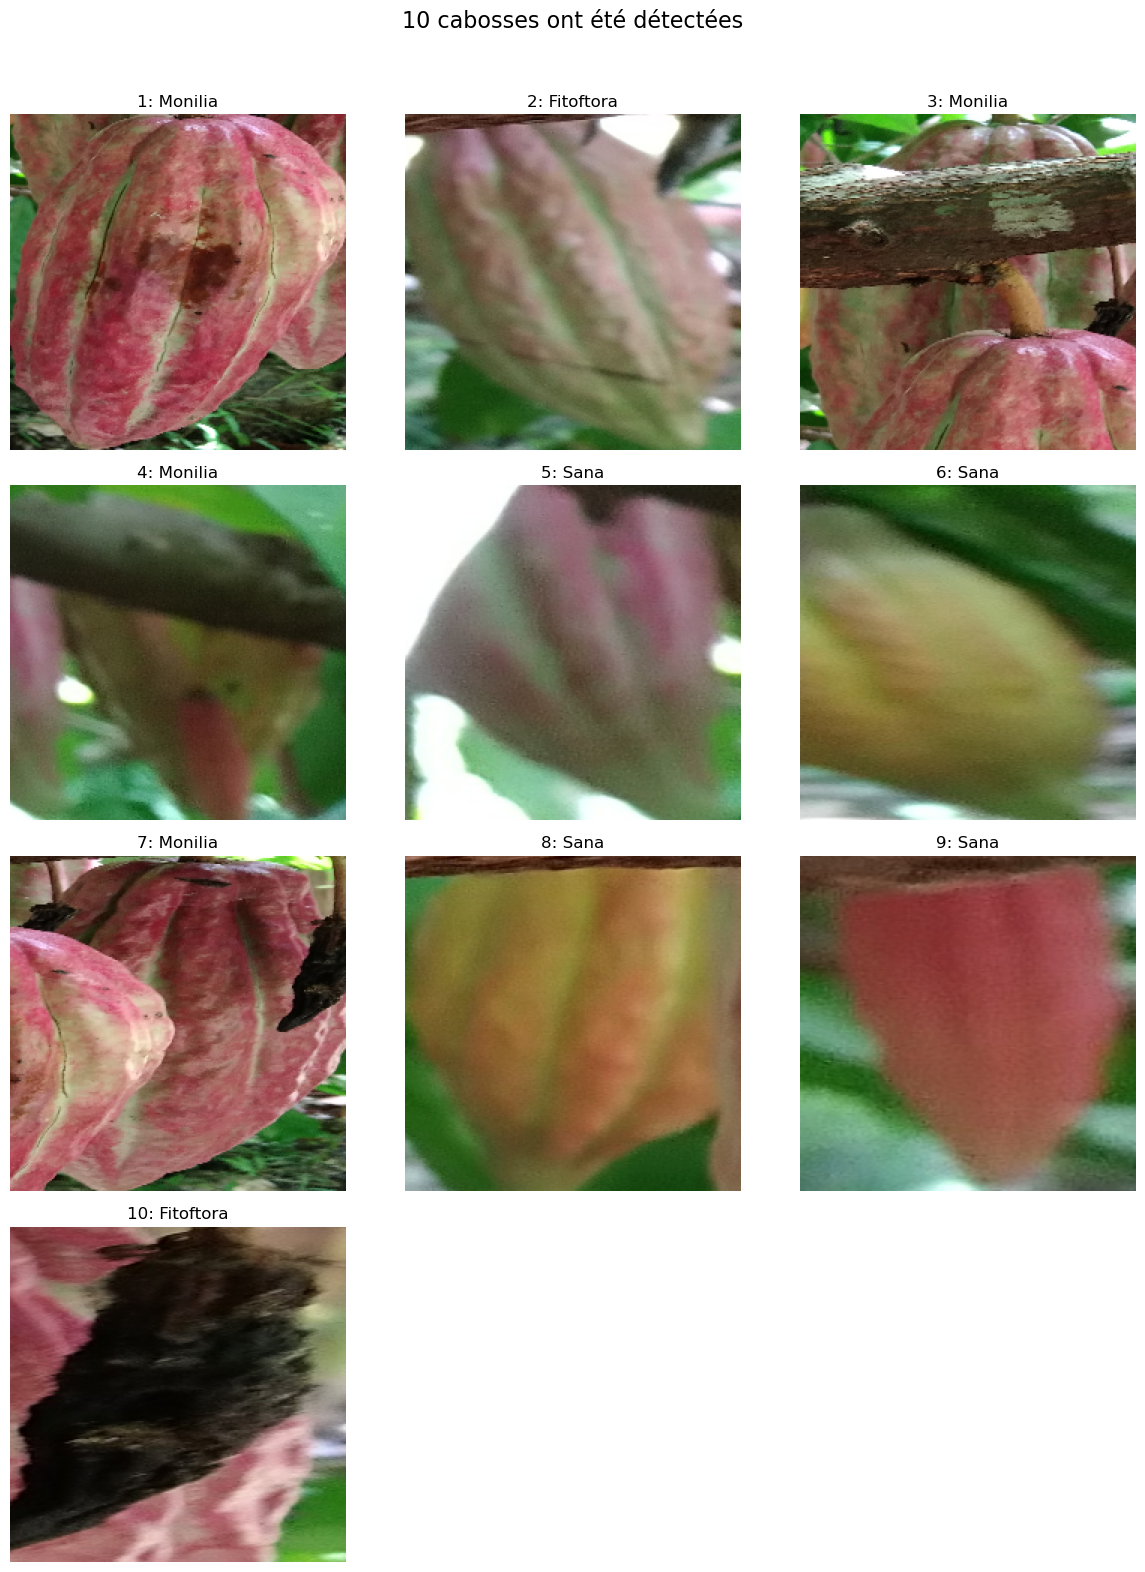

In [ ]:
# Charger le modèle YOLO
model = YOLO("models/yolov5/best.pt")

# Charger l'image
image_path = "Images/image1.jpg"
image_cv = cv2.imread(image_path)

# Détection
results = model(image_path)

# Stockage des cabosses extraites
cabosses = []

# Taille cible (à adapter selon ton modèle de classification)
target_size = (224, 224)

# Parcourir les prédictions
for r in results:
    for box in r.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        roi = image_cv[y1:y2, x1:x2]
        
        # Vérification taille minimale pour éviter erreurs
        if roi.shape[0] > 10 and roi.shape[1] > 10:
            # Redimensionner
            roi_resized = cv2.resize(roi, target_size)
            cabosses.append(roi_resized)

# Convertir en tableau NumPy (N, H, W, C)
cabosses = np.array(cabosses)


# Charger les modèles
pca = joblib.load('pca_model.pkl')
svm = joblib.load('SVM_model.pkl')

# Étape 1 : Extraire les features sur chaque image (à adapter à ta fonction d'extraction)
all_features = extractor.extract_all_features(cabosses)

# Étape 2 : Réduction de dimension
pca_features = pca.transform(all_features)

# Étape 3 : Prédiction
predictions = svm.predict(pca_features)

# Étape 4 : Affichage avec matplotlib
class_names = ['Fitoftora', 'Monilia', 'Sana']

nb_cabosses = len(cabosses)

if nb_cabosses == 1:
    titre = "Une cabosse a été détectée"
else:
    titre = f"{nb_cabosses} cabosses ont été détectées"

# Affichage
cols = 3
rows = (nb_cabosses + cols - 1) // cols

plt.figure(figsize=(12, 4 * rows))

for i in range(nb_cabosses):
    cabosse_rgb = cv2.cvtColor(cabosses[i], cv2.COLOR_BGR2RGB)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cabosse_rgb)
    plt.title(f"{i+1}: {class_names[predictions[i]]}")
    plt.axis("off")

plt.suptitle(titre, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
